Explain this

In [68]:
# random
from random import random

# math functions
from math import cos, sin
from math import atan2, pi

# load MDAnalysis library 
# to deal with GRO/XTC files
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.dihedrals import Dihedral
from MDAnalysis.analysis.dihedrals import Ramachandran

# arrays
import numpy as np

# machine learning
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

start. I will avoid fitting (rot+trans) for now

In [2]:
# define path to structure files
PATHD = "../datasets/trajectories/"
FRAME = PATHD + "CLCec1_anton2_restrained_15us.gro"
TRAJ1 = PATHD + "CLCec1_anton2_restrained_15us.xtc"
TRAJ2 = PATHD + "CLCec1_anton2_unrestrain_15us.xtc"

# load traj files
rest = mda.Universe(FRAME,TRAJ1)
unrs = mda.Universe(FRAME,TRAJ2)
#trj = mda.Universe(FRAME,[TRAJ1,TRAJ2])

In [3]:
# fitting
#ref = mda.Universe(FRAME)
#fit = align.AlignTraj(trj, ref, select="protein and name CA", in_memory=True)
#fit.run()

Ramachandran analysis
----------------------------

Let's compare both trajectories using a simple dihedral analysis, no fitting requiered

In [4]:
# select protein residues
restrained = rest.select_atoms("protein and resid 2-429")
unrestrain = unrs.select_atoms("protein and resid 2-429")

# quick calculation of phi and psi angles
R = Ramachandran(restrained).run()
U = Ramachandran(unrestrain).run()

plotting

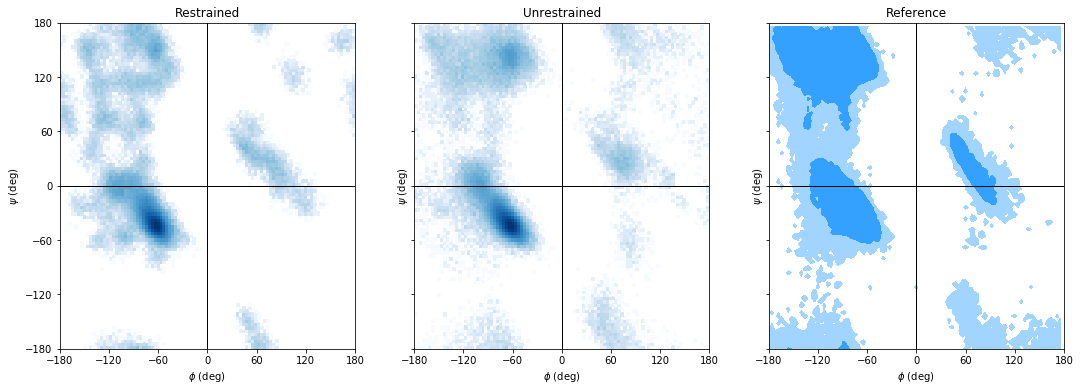

In [5]:
# create a figure and three subplots
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(18,6))

# axes decoration
for ax in axes:
    ax.axis([-180,180,-180,180])
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    ax.set(xticks=range(-180, 181, 60), yticks=range(-180, 181, 60),
           xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")

# set titles    
axes[0].title.set_text('Restrained')
axes[1].title.set_text('Unrestrained')
axes[2].title.set_text('Reference')
    
# reshape angle arrays
r = R.angles.reshape(np.prod(R.angles.shape[:2]), 2)
u = U.angles.reshape(np.prod(U.angles.shape[:2]), 2)

# plot backbone dihedral maps for all frames
axes[0].hist2d(r[:,0], r[:,1], bins=100, range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)
axes[1].hist2d(u[:,0], u[:,1], bins=100, range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)

# plot reference map which shows allowed and marginally allowed regions
U.plot(ax=axes[2], color='k', marker=".", alpha=0.0, ref=True)

plt.show()

the **Unrestrained** is more flexible, as expected, but also more similar to the **Reference** map. 
At least for me, in a qualitative way. 

Dihedral PCA
----------------

Let's compare the 2 trajectories!

In [368]:
# dimensions
#frames, angles = 300, 856

# reshape angle arrays
#rsss = r.reshape(300, 856)
#usss = u.reshape(300, 856)

# convert to radians
#rsss = np.deg2rad(rsss)
#usss = np.deg2rad(usss)

# calculate cos and sin 
# of phi, psi angles
#pcos = np.cos(np.vstack((rsss,usss)))
#psin = np.sin(np.vstack((rsss,usss)))
#data = np.hstack((pcos, psin))

In [6]:
# reshape angle arrays
r = R.angles.reshape(np.prod(R.angles.shape[:2]), 2)
u = U.angles.reshape(np.prod(U.angles.shape[:2]), 2)

# convert to radians
ress = np.deg2rad(r)
unre = np.deg2rad(u)

# combine datasets
data = np.vstack((ress,unre))

In [58]:
# calculate angular mean
def circmean(angles):
    # transformation
    c = np.cos(angles)
    s = np.sin(angles)
    # average
    return atan2(np.average(s), np.average(c))

# minimum distance 
# between 2 angles
def dangle(x, y):
    # x is the target angle
    # y is the source or starting angle
    return atan2(sin(x-y), cos(x-y))

# wrap coordinates 
def wrap(angles, delta):
    circle = 2.*pi
    return (angles - delta) % circle - pi

# rotate angles
def rotate(angles, theta):
    # cartesian transform
    x = np.vstack((np.cos(angles), 
                   np.sin(angles)))
    # rotation matrix
    c = np.cos(theta)
    s = np.sin(theta)
    y = np.array(((c,-s), (s, c)))
    # apply rotation
    z = np.dot(y, x)
    # return new angles
    return np.arctan2(z[1,:], z[0,:])

# estimate low density states
def lowdens(angles):
    '''comment reference'''
    # binwidth 5 degress
    bw = pi*5./180.
    # calculate density
    dens, edges = np.histogram(angles, 
                               bins=np.arange(-pi,pi,bw), 
                               density=True)
    # order descendent
    low = np.sort(dens, axis=None)[0]
    # index of lowest dens
    idx = np.where(dens == low)
    # return bin edge
    return edges[idx][0]

In [100]:
A = data[:,0]
B = data[:,1]
    
# loss function
def loss(angles, factor):
    c = dangle(np.average(angles), circmean(angles))
    d = dangle(lowdens(angles), -pi)
    return (factor*c)**2 + d**2

# gradient descent
def grad(angles, factor, step=0.1):
    dfdx = 2. * factor
    # substract
    factor -= step * dfdx
    return factor

# intitalize factors
a = random()
b = random() 

# calc loss function
chi = loss(A,a) + loss(B,b)
delta = chi
print("loss", chi, abs(delta))

# minimize
while abs(delta) > 0.001:
    delta = chi
    # translate
    A = wrap(A, lowdens(A))
    B = wrap(B, lowdens(B))
    # calc rot angles
    a = grad(A,a)
    b = grad(B,b)
    # rotate
    A = rotate(A,a)
    B = rotate(B,b)
    # calc loss
    chi = loss(A,a) + loss(B,b)
    # calculate loss change
    delta -= chi

print("loss", chi, abs(delta))

loss 11.85518278400067 11.85518278400067
loss 0.01625959018892665 0.0005785442823907638


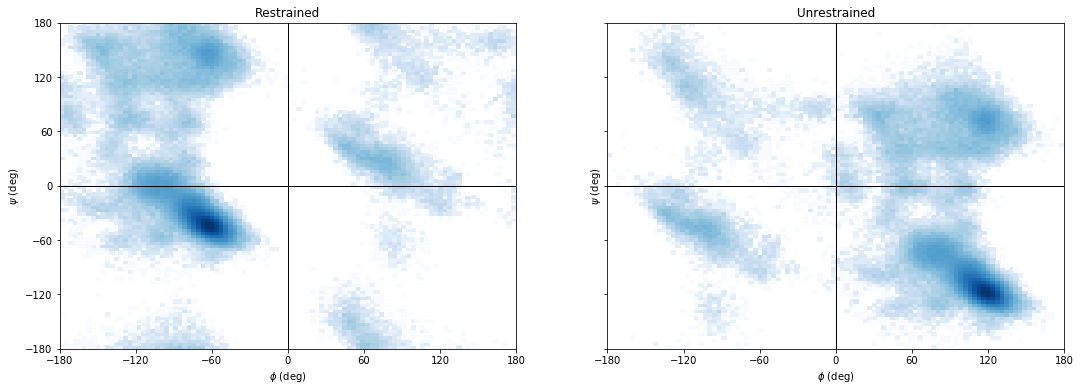

In [110]:
# create a figure and three subplots
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(18,6))

# axes decoration
for ax in axes:
    ax.axis([-180,180,-180,180])
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    ax.set(xticks=range(-180, 181, 60), yticks=range(-180, 181, 60),
           xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")

# set titles    
axes[0].title.set_text('Restrained')
axes[1].title.set_text('Unrestrained')

# plot backbone dihedral maps for all frames
axes[0].hist2d(np.degrees(data[:,0]), np.degrees(data[:,1]), bins=100, 
               range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)
axes[1].hist2d(np.degrees(A), np.degrees(B), bins=100, 
               range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)

plt.show()

In [111]:
# reshape angle arrays
xsss = np.hstack((A,B)).reshape(600, 856)

# calculate cos and sin 
# of phi, psi angles
pcos = np.cos(xsss)
psin = np.sin(xsss)
data = np.hstack((pcos, psin))
# standardize data
#scaler = StandardScaler()
#datset = scaler.fit_transform(data)
# get PCA projection 
pca = PCA(n_components=100)
vec = pca.fit_transform(data)

In [112]:
pca.explained_variance_ratio_
print(vec.shape)

(600, 100)


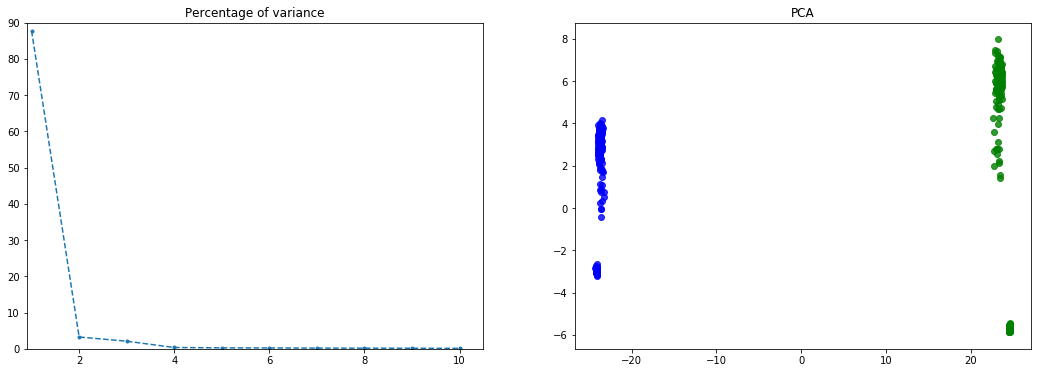

In [113]:
# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.axis([0.9,10.5,0,90])
ax1.title.set_text('Percentage of variance')
#ax1.set(yticks=range(0, 21, 5), xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")
ax1.plot(range(1,11), pca.explained_variance_ratio_[:10]*100, marker='.', linestyle='dashed')

#ax2.axis([-15,15,-8,8])
ax2.title.set_text('PCA')
#ax2.set(xticks=range(-12, 13, 4), xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")
ax2.scatter(vec[:300,0], vec[:300,1], color='blue',  alpha=.8, label='traj1')
ax2.scatter(vec[300:,0], vec[300:,1], color='green', alpha=.8, label='traj2')

In [187]:
# select only calpha carbons
protein = trj.select_atoms("name CA")

# get cartesian positions for traj1 and 2
trajCA = np.array([protein.positions for ts in trj.trajectory])

NameError: name 'trj' is not defined

In [11]:
# scikit-learn expects 2d numpy arrays
# for the training dataset
frames, atoms, dimensions = trajCA.shape
# change dimensions
dataset = trajCA.reshape((frames,atoms*dimensions))

# get PCA projection 
pca = PCA(n_components=2)
vec = pca.fit(dataset).transform(dataset)

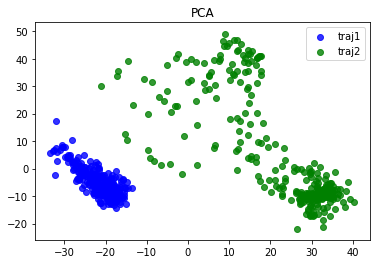

In [12]:
# plot
plt.scatter(vec[:300,0], vec[:300,1], color='blue',  alpha=.8, label='traj1')
plt.scatter(vec[300:,0], vec[300:,1], color='green', alpha=.8, label='traj2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()

In [13]:
kpca = KernelPCA(kernel="cosine", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(dataset)

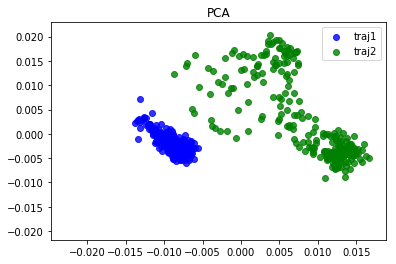

In [14]:
# plot
plt.scatter(X_kpca[:300,0], X_kpca[:300,1], color='blue',  alpha=.8, label='traj1')
plt.scatter(X_kpca[300:,0], X_kpca[300:,1], color='green', alpha=.8, label='traj2')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA')
plt.show()